# RAPID transfer Neural Networks

_Author: Aline Van Driessche_

This notebook contains all code needed to perform CNN training on individual latitudes (satellite observable variables available from ECCO) and RAPID information, from the in-situ array at 26.5°N. Read section headings for more details on setup, preprocessing, and model training.

# Setup

Importing relevant modules and custom scripts. A number of helper functions are also defined to clean up experiment code.

In [111]:
import os
import sys

import numpy as np
import pandas as pd

import paths
import pickle
import importlib
from tqdm import tqdm

sys.path.append("..")
from models.utils import *
from models.plotting_utils import *
import statsmodels.api as sm
from sklearn.metrics import *
import matplotlib.pyplot as plt

from models import train, CNN1D, CNN2D

In [112]:
# A helper function to add lags to the input (RAPID) dataset
def add_lags_inputs(inputs, num_months_lags):
    inputs = inputs.copy(deep = True)
    
    for field in inputs:
        for i in num_months_lags:
                inputs[f'{field}_lag{i}'] = inputs[field].shift(time = i)

    return inputs

In [113]:
# A helper function to format RAPID in the same way as the other output streamfunctions for training
def format_RAPID(RAPID_path):
    
    PSI_RAPID = xr.open_dataset(RAPID_path)

    PSI_RAPID['depth'] = - PSI_RAPID['depth']
    PSI_RAPID = (PSI_RAPID
                 .rename({'depth': 'Z'})
                 .rename_vars({'stream_function_mar': 'psi_moc'})
                 .assign_coords(k=('k', np.arange(len(PSI_RAPID.depth.values)))))

    PSI_RAPID['psi_moc'] = (('k', 'time'), PSI_RAPID['psi_moc'].values)
    PSI_RAPID['psi_moc'] = PSI_RAPID['psi_moc'].expand_dims({'latitude': [26.5], 'longitude': [0.0]})
    return PSI_RAPID

In [114]:
# A helper function to extract the streamfunction at the level (depth or density) where the moc is maximal in a southern (max) or northern direction (min)
def get_PSI_at_max_density_level(PSI, moc_param="psi_moc", max=True):
    PSI_mean = PSI[moc_param].mean("time")  # np.abs()
    if max is True:
        max_index = PSI_mean.argmax(dim="k")
    else:
        max_index = PSI_mean.argmin(dim="k")
    return PSI.isel(k=max_index)

In [115]:
# A helper function to format the input files based on a given latitude
def format_lat_lon(value):
    """Format latitude or longitude with N/S or E/W suffix."""
    if value < 0:
        return f"{abs(value)}S"
    else:
        return f"{value}N"

In [116]:
# Helper function to align the dates of RAPID inputs and ECCO data
def clip_dates(RAPID_inputs, inputs, full_outputs):

    # RAPID has the latest start date and the ECCO data has the earliest end date (combine)
    date_range = (RAPID_inputs.dropna(dim='time', how='any').time.values[0], inputs.time.values[-1]) 
    date_range = tuple([str(d).split('T')[0] for d in date_range]) # extracting just the date, w/o time
    #print('Date range to align to:', date_range)

    # Align the surface variable inputs with RAPID, then align the in- and outputs
    inputs, RAPID_inputs = align_inputs_outputs(inputs, RAPID_inputs, date_range = date_range, ecco=False)
    inputs, outputs = align_inputs_outputs(inputs, full_outputs, date_range = date_range, ecco=False)
    return inputs, RAPID_inputs, outputs

## Experiment Variables

All variables that might be worth changing during experiments.

In [129]:
# CONSTANTS
data_home = paths.LOCAL_DIR
# We are specifically interested in the atlantic mask at 30S (mass conservation from 26°N)
lat = -30           
atlantic_lon_min = -50
atlantic_lon_max = 17

cell_of_interest = "abyssal"

remove_season = False
remove_trend = False

input_vars = ['OBP', 'ZWS', 'SST'] #other options are 'SSH', 'SSS', 'SST'

history_surface_vars =1
moc_rapid_timelag = 12
range_rapid_timelags = 138 #11.5 years 
repetitions_timelag = 1
intervals_timelag = 3

zonal_avg = ['time']
no_zonal_avgs = ['time', 'longitude']   #for 2D training this setting is necessary

ECCO_GRID = xr.open_dataset(paths.geom_fp)
RAPID_path = os.path.join(paths.RAPID_ARRAY, "moc_vertical.nc")
inputs_path = f"{data_home}/ecco_data_minimal/{format_lat_lon(lat)}.nc"
strf_30S_path = f"{data_home}/ecco_data_minimal/{format_lat_lon(lat)}_atlantic_sf_depth.pickle"

# HYPERPARAMETERS
dropout = 0.1
n_pure_layers = 1
n_mix_layers = 2
n_channels_mult = 4
kernel_size = 5          #For 2D input change this to (3x3)
model_iterations = 3

## Loading and processing relevant data
Data loading function that extracted and preprocesses the data as defined in the “Experiment Variables” section and returns the in- and output for training. For reproduction, the RAPID streamfunction can be downloaded from the 'rapid.ac.uk' website, the satellite observable variables and the native ECCO grid from the NASA's 'PO.DAAC' website and finally the streamfunction (in depth space) at 30°S can be calculated with 'sf_sl.ipynb' (be careful to use the atlantic basin mask).

In [130]:
# Load the input RAPID moc strength, resample to monthly mean values and calculate the timelag up to 12 years (144 months). 
PSI_RAPID = format_RAPID(RAPID_path).resample(time='1ME').mean()

RAPID_inputs = get_PSI_at_max_density_level(
                    PSI_RAPID, moc_param='psi_moc', max=True
                ).drop_vars('Z')
RAPID_all_inputs = add_lags_inputs(RAPID_inputs, range(range_rapid_timelags))  

In [131]:
# Load the satellite observable variables at 30°S, use the atlantic basin mask
inputs_ecco = xr.open_dataset(inputs_path).isel(latitude=slice(1,2))
inputs_ecco = inputs_ecco.sel(longitude=slice(atlantic_lon_min, atlantic_lon_max))

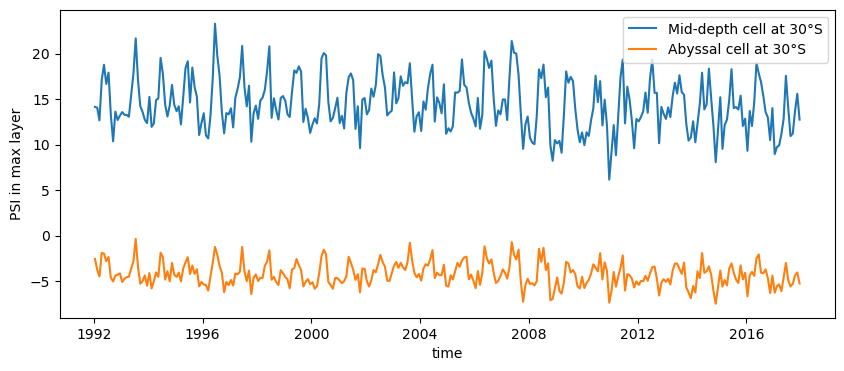

In [132]:
# Load the 30S streamfunction and calculate the moc strength in the abyssal and mid-depth cell, plot both functions. 
with open(strf_30S_path, 'rb') as f:
    strf = pickle.load(f).astype(np.float64)[::-1] #Invert the depth values

strf = np.expand_dims(strf[:, 1, :], 1) # grabbing just 30S
strf = np.transpose(strf, (2,0,1))
    
strf = xr.Dataset(
        data_vars = {'moc' : (["time", "k", "latitude"], strf)}, 
        coords = {'time' : inputs_ecco.time,  'k': np.arange(50), 'latitude' : np.atleast_1d(-60)}
        )
strf = strf.assign_coords(Z=('k', ECCO_GRID.coords['Z'].data))

moc_30S_middepth_cell = get_PSI_at_max_density_level(strf.squeeze(), moc_param='moc', max=True)
moc_30S_abyssal_cell = get_PSI_at_max_density_level(strf.squeeze(), moc_param='moc', max=False)

# Plot both streamfunctions for a sanity check
plt.figure(figsize = (10, 4))
plt.plot(moc_30S_middepth_cell["time"].squeeze(), moc_30S_middepth_cell["moc"].squeeze(), label='Mid-depth cell at 30°S')   
plt.plot(moc_30S_abyssal_cell["time"].squeeze(), moc_30S_abyssal_cell["moc"].squeeze(), label='Abyssal cell at 30°S') 
plt.xlabel('time')
plt.ylabel('PSI in max layer')
plt.legend()

In [133]:
def retrieve_data(inputs=inputs_ecco, input_rapid=RAPID_all_inputs, output_type=cell_of_interest, history=history_surface_vars, rapid_timelag=moc_rapid_timelag, repetitions_timelag=repetitions_timelag, intervals_timelag=intervals_timelag, coords = zonal_avg, input_vars=input_vars, remove_trend=remove_trend, remove_season=remove_season, mode='combined', verbose=False):
    
    # Retrieve the RAPID input with the appropriate timelag(s)
    data_vars = [f"psi_moc_lag{rapid_timelag}"]
    for interval_nr in range(int(repetitions_timelag*12/intervals_timelag)):
        data_vars.append(f"psi_moc_lag{rapid_timelag+((interval_nr+1)*intervals_timelag)}")
    RAPID_inputs = input_rapid[data_vars]
    
    # Define which output moc we will try to predict
    if output_type == 'abyssal':
        outputs = moc_30S_abyssal_cell
    elif output_type == 'middepth':
        outputs = moc_30S_middepth_cell
    
    # Clip all the in- and outputs to the same daterange
    inputs, RAPID_inputs, outputs = clip_dates(RAPID_inputs, inputs, outputs)
    
    # Preprocess both surface variables and the RAPID input data
    pp_data_RAPID = apply_preprocessing(RAPID_inputs,
                                    mode="inputs",
                                    remove_season=remove_season,
                                    remove_trend=remove_trend,
                                    standardize=True,
                                    lowpass=False)

    pp_data_surface = apply_preprocessing(inputs,
                              mode="inputs",
                              remove_season=remove_season,
                              remove_trend=remove_trend,
                              standardize=True,
                              lowpass=False)

    # reshape as desired and convert to a numpy array
    pp_data_RAPID_np = reshape_inputs(pp_data_RAPID, history=history, keep_coords=coords, data_vars=data_vars, verbose=False)
    pp_data_SURFACE_np = reshape_inputs(pp_data_surface, history=history, keep_coords=coords, data_vars=input_vars, verbose=False)

    # Concatenate the different information layers together
    if mode == 'RAPID':
        X = pp_data_RAPID_np
    elif mode == 'surface variables':
        X = pp_data_SURFACE_np
    elif mode == 'combined':
        X = np.concatenate((pp_data_RAPID_np, pp_data_SURFACE_np), axis=-1)
    
    # Necessary transpose for convolutions with PyTorch Tensors + adjusting the shape to suit as CNN input
    dims = list(range(X.ndim))  
    dims[1], dims[-1] = dims[-1], dims[1]
    X = np.transpose(X, dims)
    if len(X.shape) == 2:
        X = np.expand_dims(X, axis=-1)
    
    # MOC strength preprocessing
    strength = apply_preprocessing(outputs,
                               mode="outputs",
                               remove_season=remove_season,
                               remove_trend=remove_trend,
                               standardize=False,
                               lowpass=False)
    strength_np = strength.moc.squeeze().values
    y = strength_np[-X.shape[0]:]
    
    if verbose is not False:
        print()
        print('Inputs shape:', X.shape)
        print('Outputs shape:', y.shape)
    return X, y

## Running Experiments

Data is extracted and preprocessed as defined in the "Experiment Variables" section. We perform a neural network training using the hyperparameters as described above. The paper outlines which metrics generate the best performances for each latitude. Our five metrics (RMSE, MAE, MAPE, $R^2$, correlation) are then calculated.

In [173]:
# Training setup (to be used in experiments below)
def train_CNN(X, y, type='1DCNN', shuffle=False):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=shuffle, stratify=None, random_state=123456)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=shuffle, stratify=None, random_state=123456)

    device = "cuda" if t.cuda.is_available() else "cpu"

    Xt_train = t.tensor(X_train, device=device)
    Yt_train = t.tensor(y_train, device=device)
    Xt_valid = t.tensor(X_valid, device=device).double()
    Yt_valid = t.tensor(y_valid, device=device).double()
    Xt_test = t.tensor(X_test, device=device).double()
    Yt_test = t.tensor(y_test, device=device).double()

    if type == '1DCNN':
        model = CNN1D.CNN1D(
            n_pure_layers=n_pure_layers, 
            n_mix_layers=n_mix_layers, 
            n_features=Xt_train.shape[1], 
            n_channels=Xt_train.shape[1]*n_channels_mult,
            kernel_size=kernel_size,
            dropout=dropout, 
        ).double()
    elif type == '2DCNN':
        model = CNN2D.CNN2D(
            n_pure_layers=n_pure_layers, 
            n_mix_layers=n_mix_layers, 
            n_features=Xt_train.shape[1], 
            n_channels=Xt_train.shape[1]*n_channels_mult,
            kernel_size=(kernel_size,kernel_size),
            dropout=dropout, 
        ).double()

    model, train_loss, val_loss = train.train_model( 
        model=model, 
        dtype='double',
        X_train = Xt_train, 
        y_train = Yt_train, 
        X_val = Xt_valid,
        y_val = Yt_valid, 
        early_stopping=True,
        min_delta=0.01, 
        threshold=5
    )
    
    # Extracting all predictions in time order
    train_set_pred = train.predict(model, Xt_train, Yt_train)
    valid_set_pred = train.predict(model, Xt_valid, Yt_valid)
    test_set_pred = train.predict(model, Xt_test, Yt_test)
    
    predictions = {
        "train_set_pred": train_set_pred, 
        "valid_set_pred": valid_set_pred, 
        "test_set_pred": test_set_pred, 
        "all_preds": np.concatenate([train_set_pred, valid_set_pred, test_set_pred])
    }
    
    metrics = {
        "rmse": round(root_mean_squared_error(test_set_pred, y_test), 3),
        "mae": round(mean_absolute_error(test_set_pred, y_test), 3),
        "mape": round(mean_absolute_percentage_error(test_set_pred, y_test), 3)*100,        
        "cmape": round(custom_MAPE(np.array(test_set_pred).squeeze(), y_test, threshold=0.5), 3)*100,
        "test_corr": round(np.corrcoef(np.array(test_set_pred).squeeze(), y_test)[0, 1], 3),
        }
    
    return metrics, predictions

#### Experiment 1. 
Running 1 1D-CNN model with the parameters as explained in the "Experiment variables" section including surface variables and RAPID.

device: cpu
33553 parameters.


100%|██████████| 2500/2500 [00:29<00:00, 84.99it/s]


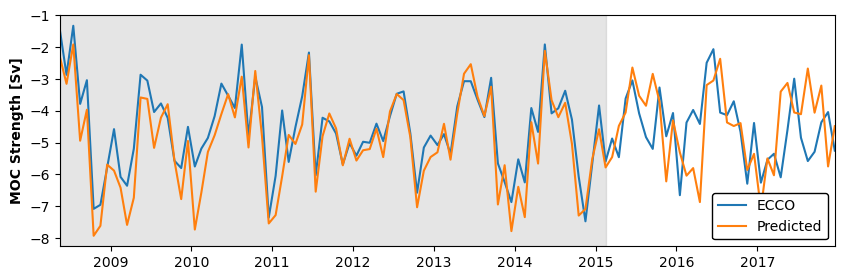

{'rmse': 1.403, 'mae': 1.194, 'mape': 29.9, 'cmape': 29.9, 'test_corr': 0.352}

In [135]:
X, y = retrieve_data(rapid_timelag=0, mode='combined', repetitions_timelag=4, input_vars=['SSH'], output_type='abyssal')
metric_dict, preds_dict = train_CNN(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, stratify=None, random_state=123456)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, stratify=None, random_state=123456)

time = inputs_ecco.time.values[-len(X):]
fig, ax = timeseries_comparison(preds_dict['all_preds'], y, time, len(X_train))
plt.show()
metric_dict

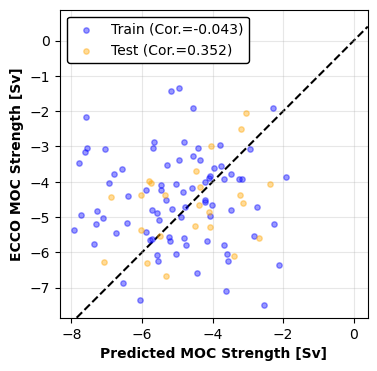

In [136]:
# Alternate view: looking at a scatterplot of predicted vs. actual
y_pred_train = np.array(preds_dict['train_set_pred']).squeeze()
y_pred_test = np.array(preds_dict['test_set_pred']).squeeze()

fig, ax = pred_vs_actual(y_pred_train, y_pred_test, y_train, y_test)
plt.show()

#### Experiment 2. 

Running the same model (here showed 1 time to reduce the computations, but can be raised for validation) with varying timelag from the RAPID data to assess the transfer of information over time. Example here is for the 'combined' mode, but RAPID and the surface variables can also be assessed separate.

In [ ]:
mode = 'surface variables'

metrics = []
preds = []
#model_iterations = 100

for rapid_timelag in range(10):
    X, y = retrieve_data(rapid_timelag=rapid_timelag, mode=mode, repetitions_timelag=1, input_vars=['OBP', 'ZWS'], output_type='abyssal')
    metric_dict, preds_dict = train_CNN(X, y, shuffle=True)
    metrics.append(metric_dict)
    preds.append(preds_dict)
    metrics_df = pd.DataFrame(metrics)
    
metrics_df.to_csv(f"{paths.LOCAL_DIR}/plotting_data_aline/NN_{mode}_abyssal_1fold.csv")

In [171]:
surf_path = f"{paths.LOCAL_DIR}/plotting_data_aline/NN_surface variables_abyssal_1fold.csv"
mean_surf = pd.read_csv(surf_path).mean()
mean_surf

Unnamed: 0     2.0000
rmse           0.8756
mae            0.7070
mape          14.4400
cmape         14.4400
test_corr      0.7194
dtype: float64

In [177]:
# Retrieving the data that can be obtained through x-fold NN training (RAPID alone, surface variables as baseline and combined)
RAPID_path = f"{paths.LOCAL_DIR}/plotting_data_aline/NN_RAPID_abyssal_1fold.csv"
mean_RAPID = pd.read_csv(RAPID_path)
rolling_mean_RAPID = mean_RAPID['mape'].rolling(window=6, min_periods=1).mean()

surf_path = f"{paths.LOCAL_DIR}/plotting_data_aline/NN_surface variables_abyssal_1fold.csv"
mean_surf = pd.read_csv(surf_path).mean() 

combo_path = f"{paths.LOCAL_DIR}/plotting_data_aline/NN_combined_abyssal_1fold.csv"
mean_combo = pd.read_csv(combo_path)
rolling_mean_combo = mean_combo['mape'].rolling(window=6, min_periods=1).mean()

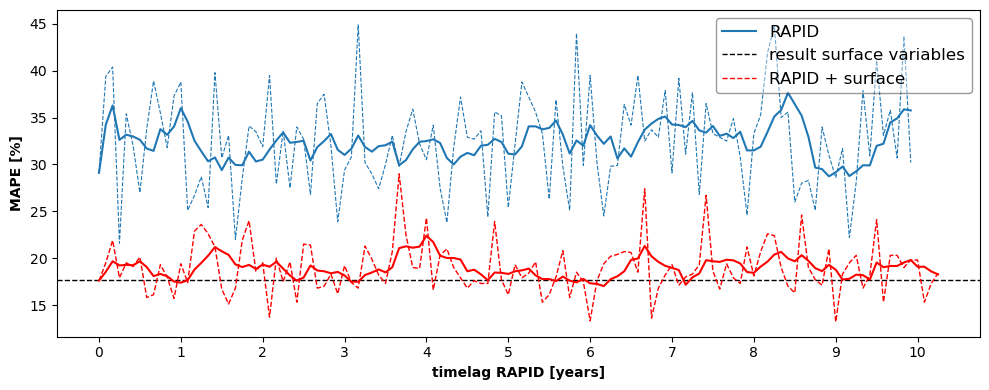

In [178]:
# Plotting the figures for NN training together
plt.figure(figsize=(10, 4))
plt.plot(mean_RAPID.index, mean_RAPID['mape'], linestyle='--', color='tab:blue', linewidth=0.8)  
plt.plot(mean_RAPID.index, rolling_mean_RAPID, color='tab:blue', label='RAPID')

plt.axhline(y=mean_surf['mape'], color='black', linestyle='--', label='result surface variables', linewidth=1.0), 

plt.plot(mean_combo.index, mean_combo['mape'], linestyle='--', color='red', linewidth=1.0, label='RAPID + surface') 
plt.plot(mean_combo.index, rolling_mean_combo, color='red')
plt.xlabel('timelag RAPID [years]', weight="bold")
plt.ylabel('MAPE [%]', weight="bold")
plt.xticks(np.arange(0, 122, 12), labels=[f'{i}' for i in range(11)]) 
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area.
plt.legend(loc='upper right', edgecolor = 'black', framealpha = 0.4, fontsize=12)
plt.savefig(f"C:/Users/aline/OTP/plots/timelagRAPID_CNN.png", dpi=400)
plt.show()